In [8]:
!pip install transformers torch scikit-learn pandas

# Importing Libraries

In [9]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing and Category Distribution Analysis

In [11]:
data_file = "/content/drive/MyDrive/Colab Notebooks/Twitter_Data.csv"
df = pd.read_csv(data_file)
df.dropna(subset=['category'], inplace=True)
# df = df.drop(df[df['category'] == 0].index)
df=df.sample(12000)
df['clean_text']=[str(i) for i in df['clean_text']]
df['category']=[int(i) for i in df['category']]
df['category']=[2 if i==1 else i for i in df['category']]
df['category']=[1 if i==0 else i for i in df['category']]
df['category']=[0 if i==-1 else i for i in df['category']]
texts = df['clean_text'].tolist()
labels=df['category'].tolist()

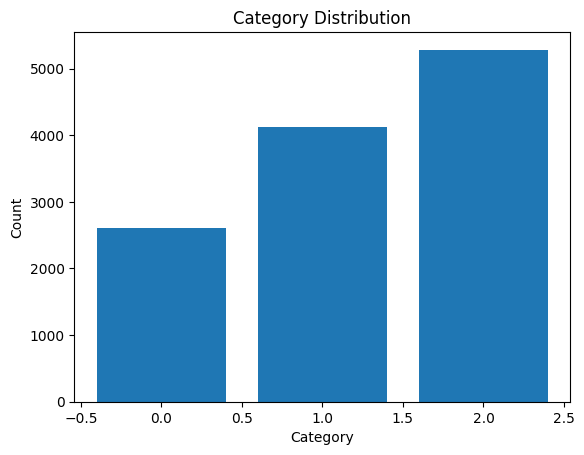

In [12]:
import matplotlib.pyplot as plt
category_counts = df['category'].value_counts()

# Plot the bar graph
plt.bar(category_counts.index, category_counts.values)

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution')

# Show the plot
plt.show()

In [13]:
df.shape

(12000, 2)

In [14]:
import random
random.choices(texts)

['the next five years could change india forever the wire ']

In [15]:
random.sample(labels,5)

[2, 1, 2, 1, 0]

# Text Classification

In [16]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


# Bert Classifier Model

In [17]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Training Functions

In [18]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [19]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [20]:
# def predict_sentiment(text, model, tokenizer, device, max_length=128):
#     model.eval()
#     encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
#     input_ids = encoding['input_ids'].to(device)
#     attention_mask = encoding['attention_mask'].to(device)

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         _, preds = torch.max(outputs, dim=2)
#     # return "positive" if preds.item() == 1 else "negative"
#     if(preds.item() == 2):
#       return "Positive Tweet"
#     if(preds.item() == 1):
#       return "Neutral Tweet"
#     if(preds.item() == 0):
#       return "Negative Tweet"

def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)  # Assuming logits is the output of your model
    label = preds.item()

    if label == 2:
        return "Positive Tweet"
    elif label == 1:
        return "Neutral Tweet"
    elif label == 0:
        return "Negative Tweet"
    else:
        return "Unknown Label"

# Assuming that your model outputs logits, and you want to get the class with the highest logit.


In [21]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 16
num_epochs = 3
learning_rate = 2e-5

# Load and Preprocess Data

In [22]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [23]:
random.sample(train_labels,9)

[1, 2, 1, 1, 0, 0, 0, 0, 1]

# Tokenization

In [24]:
# Specify a cache directory for the tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name, cache_dir="/path/to/cache/directory")

# Rest of your code remains the same
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Model Initialization and Training

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/6
Validation Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       507
           1       0.82      0.95      0.88       833
           2       0.92      0.86      0.89      1060

    accuracy                           0.87      2400
   macro avg       0.86      0.85      0.85      2400
weighted avg       0.87      0.87      0.87      2400

Epoch 2/6
Validation Accuracy: 0.8962
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       507
           1       0.92      0.92      0.92       833
           2       0.86      0.95      0.91      1060

    accuracy                           0.90      2400
   macro avg       0.91      0.87      0.88      2400
weighted avg       0.90      0.90      0.89      2400

Epoch 3/6
Validation Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       507
           1   

# Save Model

In [28]:
torch.save(model.state_dict(), "bert_classifier_three_labeled.pth")

# Test Sentiment Prediction

In [29]:
# Test sentiment prediction
test_text = "PM Modi's unwavering dedication to economic development and his efforts to uplift the marginalized communities are truly commendable. His leadership has been instrumental in India's progress towards becoming a global powerhouse. #RespectForModi"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

PM Modi's unwavering dedication to economic development and his efforts to uplift the marginalized communities are truly commendable. His leadership has been instrumental in India's progress towards becoming a global powerhouse. #RespectForModi
Predicted sentiment: Positive Tweet


In [30]:
# Test sentiment prediction
test_text = "The rising unemployment rate and the widening gap between the rich and the poor under PM Modi's rule are alarming. His economic policies seem to favor the wealthy at the expense of the common people."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

The rising unemployment rate and the widening gap between the rich and the poor under PM Modi's rule are alarming. His economic policies seem to favor the wealthy at the expense of the common people.
Predicted sentiment: Negative Tweet


In [31]:
# Test sentiment prediction
test_text = "oh yah modi is now our pm"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

oh yah modi is now our pm
Predicted sentiment: Neutral Tweet
